In [1]:
%load_ext autoreload
%autoreload 2

import os
import sqlite3
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter("ignore")

FRED_API = os.getenv("FRED_API_KEY")
Q_DIR = Path().cwd().parent
DATA_DIR = Q_DIR / "data" / "MSCI_KOKUSAI"
PRJ_DIR = Q_DIR / "A_001"
# Factset Benchmark directory
BM_DIR = Q_DIR / "data/Factset/Benchmark"
FRED_DIR = Q_DIR / "data" / "FRED"
INDEX_DIR = Q_DIR / "data" / "Factset" / "Index"

In [ ]:
df = pd.read_parquet(INDEX_DIR / "Index_Price-and-Valuation.parquet")
db_path = INDEX_DIR / "Index-Price-and-Valuation.db"
conn = sqlite3.connect(db_path)
for variable in df["variable"].unique():
    df_slice = df[df["variable"] == variable].reset_index(drop=True)
    df_slice.to_sql(variable, conn, index=False, if_exists="replace")
conn.close()

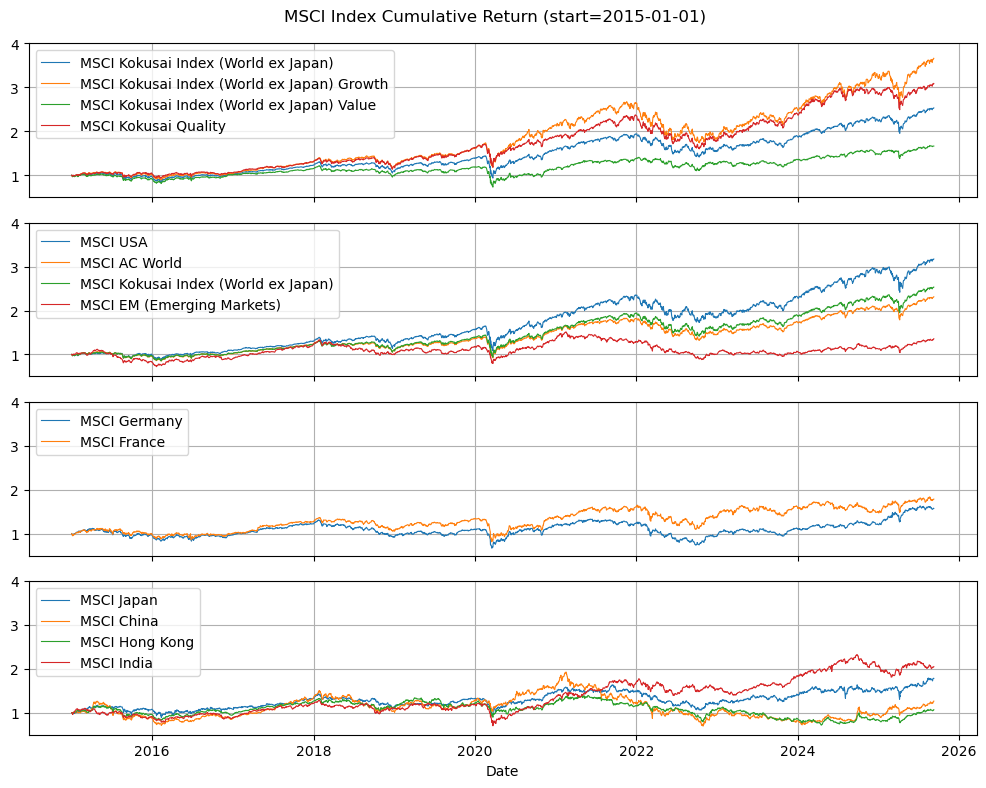

In [ ]:
conn = sqlite3.connect(db_path)
df_price = pd.read_sql("SELECT * FROM FG_PRICE", con=conn).drop(columns=["variable"])
df_price = pd.pivot(
    df_price, index="date", columns="Index", values="value"
).sort_index()
df_price.index = pd.to_datetime(df_price.index)
# display(df_price)

start_date = pd.to_datetime("2015-01-01")
df_price_slice = df_price.loc[start_date:]
df_return_daily = np.log(df_price_slice) - np.log(df_price_slice.shift())
df_cum_log_return = df_return_daily.fillna(0).cumsum()
df_cum_return = np.exp(df_cum_log_return)
# display(df_cum_return.head())


df_price_monthly = df_price.asfreq("BM").sort_index()
df_return_monthly = np.log(df_price_monthly) - np.log(df_price_monthly.shift())
df_return_monthly.dropna(inplace=True)
# display(df_return_monthly.head())

df_price_annual = df_price.asfreq("BY").sort_index()
df_return_annual = np.log(df_price_annual) - np.log(df_price_annual.shift())
df_return_annual.dropna(inplace=True)
# display(df_return_annual.head())


fig, axes = plt.subplots(4, 1, figsize=(10, 8), tight_layout=True, sharex=True)
# start_date = df_cum_return.index.min()
fig.suptitle(f"MSCI Index Cumulative Return (start={start_date.strftime('%Y-%m-%d')})")
index_kokusai = [
    "MSCI Kokusai Index (World ex Japan)",
    "MSCI Kokusai Index (World ex Japan) Growth",
    "MSCI Kokusai Index (World ex Japan) Value",
    "MSCI Kokusai Quality",
]
index_usa_and_world = [
    "MSCI USA",
    "MSCI AC World",
    "MSCI Kokusai Index (World ex Japan)",
    "MSCI EM (Emerging Markets)",
]
index_europe = ["MSCI Germany", "MSCI France"]
index_asia = ["MSCI Japan", "MSCI China", "MSCI Hong Kong", "MSCI India"]
index_group = [index_kokusai, index_usa_and_world, index_europe, index_asia]

max_y_lim = 4.0
for i, index_list in enumerate(index_group):
    for col in index_list:
        sns.lineplot(
            df_cum_return,
            x=df_cum_return.index,
            y=df_cum_return[col],
            ax=axes[i],
            label=col,
            linewidth=0.8,
        )
        axes[i].legend(loc="upper left")
        axes[i].set_ylabel("")
        axes[i].set_ylim(0.5, max_y_lim)

for i in range(len(index_group)):
    axes[i].grid()
axes[-1].set_xlabel("Date")
plt.show()

### EPS


,EPS_LTM
date,
2005-09-30 00:00:00,68.975961
2005-10-31 00:00:00,69.904979
2005-11-30 00:00:00,72.902313
2005-12-30 00:00:00,72.442901
2006-01-31 00:00:00,72.114748


,EPS_LTM,price,PER,log_return,EPS_chg,cum_return
date,,,,,,
2005-09-30,68.975961,1191.366373,17.272197,0.000000,0.000000,1.000000
2005-10-31,69.904979,1159.953720,16.593292,-0.320649,0.161625,0.973633
2005-11-30,72.902313,1194.864443,16.389939,0.355832,0.514527,1.002936
2005-12-30,72.442901,1211.064713,16.717507,0.161606,-0.075621,1.016534
2006-01-31,72.114748,1263.437635,17.519823,0.508037,-0.054358,1.060495
...,...,...,...,...,...,...
2025-04-30,164.915940,3791.507248,22.990544,0.058010,0.049730,3.182486
2025-05-30,168.127737,4011.034191,23.857064,0.675426,0.233704,3.366751
2025-06-30,170.631784,4186.433120,24.534896,0.513600,0.178725,3.513976


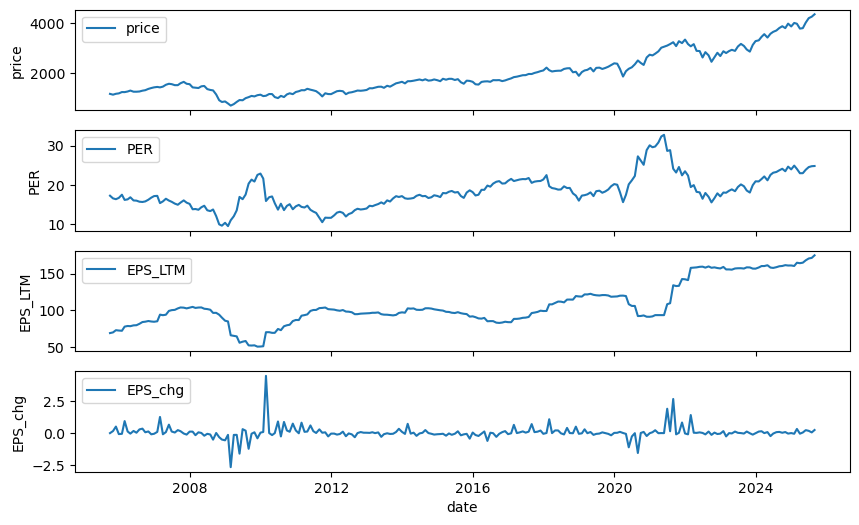

In [ ]:
db_path = INDEX_DIR / "Index-Price-and-Valuation.db"
conn = sqlite3.connect(db_path)
df_eps = pd.read_sql(
    """
        SELECT
            date, value
        FROM
            FMA_EPS_LTM
        WHERE
            `Index`=='MSCI Kokusai Index (World ex Japan)'
    """,
    con=conn,
    index_col="date",
).rename(columns={"value": "EPS_LTM"})
display(df_eps.head())

df_price = pd.read_sql(
    """
        SELECT
            date, value
        FROM
            FG_PRICE
        WHERE
            `Index`=='MSCI Kokusai Index (World ex Japan)'
    """,
    con=conn,
    index_col="date",
).rename(columns={"value": "price"})

df = pd.merge(df_eps, df_price, left_index=True, right_index=True).fillna(
    method="ffill"
)
df = (
    df.assign(
        PER=lambda row: row["price"].div(row["EPS_LTM"]),
        log_return=lambda row: (np.log(row["price"]) - np.log(row["price"].shift()))
        * 12,
        EPS_chg=lambda row: row["EPS_LTM"].pct_change() * 12,
    ).fillna(0)
    # .dropna()
    # .drop(columns=["EPS_LTM", "price", "PER"])
)
df.index = pd.to_datetime(df.index)
df["cum_return"] = np.exp(df["log_return"].div(12).cumsum())

display(df)

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
for i, col in enumerate(["price", "PER", "EPS_LTM", "EPS_chg"]):
    ax = axes[i]
    sns.lineplot(df, x=df.index, y=df[col], label=col, ax=axes[i])
    ax.legend(loc="upper left")
plt.show()

## Interest rate, ISM-PMI
